In [1]:
# pip install pandas
# !pip install mysql-connector-python
# !pip install matplotlib
!pip install seaborn

In [2]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items') 
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Prashant98#',
    database='Ecommerce_Target'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/Prashant Kumar Patel/Downloads/Ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector


db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "Prashant98#",
                            database = "Ecommerce_Target")

cur = db.cursor()

In [4]:
query = """SELECT DISTINCT customer_city FROM customers"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data,columns=["City"])
df.head()

,City
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


In [5]:
query = """SELECT COUNT(order_id) FROM ORDERS WHERE YEAR(order_purchase_timestamp)=2017"""

cur.execute(query)
data = cur.fetchall()

"Total orders placed in 2017 are", data[0][0]

('Total orders placed in 2017 are', 180404)

In [6]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

"total orders placed in 2017 are", data[0][0]

('total orders placed in 2017 are', 180404)

In [7]:
query= """SELECT UPPER(pr.product_category) as category,ROUND(SUM(p.payment_value),2) AS sales
            FROM payments p INNER JOIN order_items oi ON p.order_id=oi.order_Id
                INNER JOIN products pr on pr.product_id=oi.product_id
            GROUP BY  pr.product_category"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data,columns= ["Category","Sales"])
df

,Category,Sales
0,PERFUMERY,3.243127e+07
1,FURNITURE DECORATION,9.153129e+07
2,TELEPHONY,3.116045e+07
3,FASHION BAGS AND ACCESSORIES,1.396213e+07
4,BED TABLE BATH,1.096034e+08
...,...,...
69,CDS MUSIC DVDS,7.676352e+04
70,LA CUISINE,1.864659e+05
71,FASHION CHILDREN'S CLOTHING,5.028288e+04
72,PC GAMER,1.391635e+05


In [8]:
# Considering that 0 means No installments Plan was used and 1 means Installment Plan was used but techically both have a same meaning
query= """SELECT (SUM(CASE WHEN payment_installments>=1 THEN 1 ELSE 0 END))/COUNT(*)*100 FROM payments"""

cur.execute(query)

data = cur.fetchall()

"Percentage of orders that were paid in installments",data[0][0]

('Percentage of orders that were paid in installments', Decimal('99.9981'))

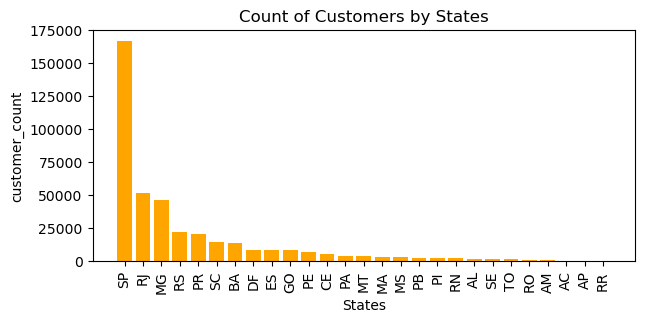

In [9]:
query = """SELECT customer_state, count(customer_Id) from customers GROUP BY customer_state"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data,columns= ['State','Customer_count'])
df = df.sort_values(by='Customer_count', ascending=False)

# Create Visual
plt.figure(figsize=(7,3))
plt.bar(df['State'],df['Customer_count'], color = "orange")
plt.xlabel("States")
plt.ylabel("customer_count")
plt.title("Count of Customers by States")
plt.xticks(rotation=90)
plt.show()

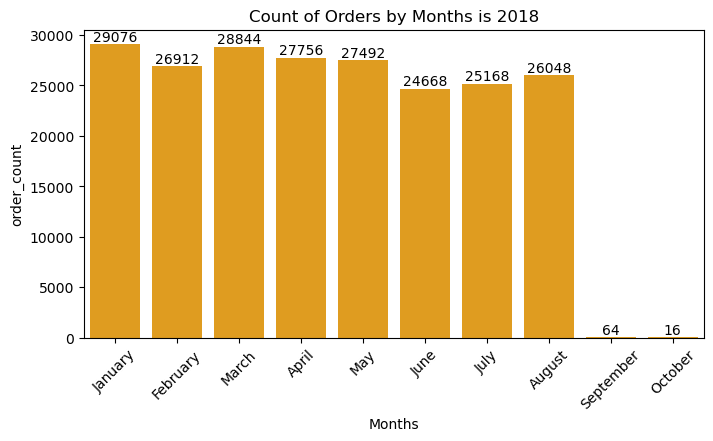

In [10]:
query = """SELECT MONTHNAME(order_purchase_timestamp) AS Months, COUNT(order_id) AS order_count FROM orders
WHERE YEAR(order_purchase_timestamp) = 2018
GROUP BY  months"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns =['Months','order_count'])
df = df.sort_values(by = 'Months', ascending = True)

o = ["January", "February","March","April","May","June","July","August","September","October"]

# Create Visual
plt.figure(figsize=(8,4))
ax = sns.barplot(x = df["Months"],y =  df["order_count"], data = df, order = o, color = "orange")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months is 2018")

plt.show()

In [11]:
query = """WITH count_per_order AS 
(SELECT orders.order_id, orders.customer_id, COUNT(order_items.order_id) AS oc
FROM orders JOIN order_items
ON orders.order_id = order_items.order_id
GROUP BY orders.order_id, orders.customer_id)

SELECT customers.customer_city, ROUND(AVG(count_per_order.oc),2) average_orders
FROM customers JOIN count_per_order
ON customers.customer_id = count_per_order.customer_id
GROUP BY customers.customer_city ORDER BY average_orders DESC
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Customer city", "Average products/order"])
df.head(10)

,Customer city,Average products/order
0,padre carvalho,112.00
1,celso ramos,104.00
2,datas,96.00
3,candido godoi,96.00
4,matias olimpio,80.00
5,cidelandia,64.00
6,curralinho,64.00
7,picarra,64.00
8,morro de sao paulo,64.00
9,teixeira soares,64.00


In [12]:
query = """select upper(products.product_category) category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc"""


cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "percentage distribution"])
df.head()

,Category,percentage distribution
0,BED TABLE BATH,171.16
1,HEALTH BEAUTY,165.65
2,COMPUTER ACCESSORIES,158.45
3,FURNITURE DECORATION,142.94
4,WATCHES PRESENT,142.84


In [14]:
import numpy as np

cur = db.cursor()
query = """select products.product_category, 
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "order_count","price"])

arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print("the correlation is", a[0][-1])

the correlation is -0.10631514167157563


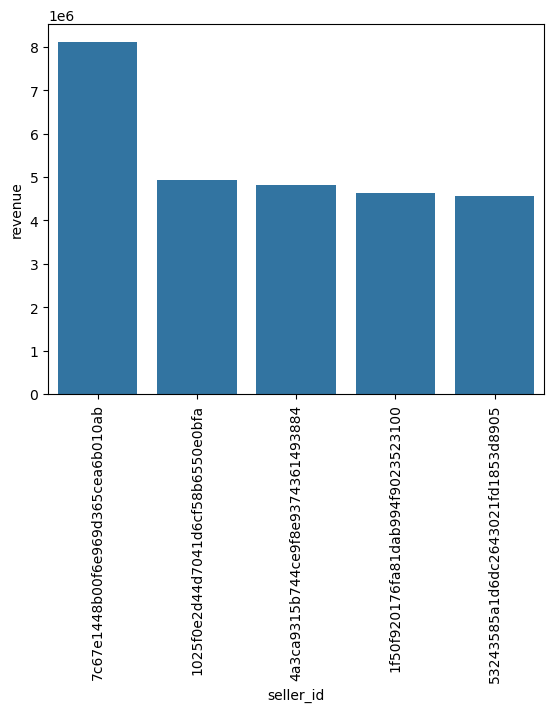

In [24]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = df.head()

# Visualize
sns.barplot(x = "seller_id", y = "revenue", data = df)
plt.xticks(rotation = 90)
plt.show()

In [26]:
query = """SELECT customer_id, order_purchase_timestamp, payment,
AVG(payment) OVER (PARTITION BY customer_id ORDER BY order_purchase_timestamp
ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) as mov_avg
FROM
(SELECT orders.customer_id, orders.order_purchase_timestamp, 
payments.payment_value as payment
FROM payments JOIN orders
on payments.order_id = orders.order_id) AS a"""


cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['customer_Id','order_purchase_timestamp','payment','mov_avg'])
df.head()

,customer_Id,order_purchase_timestamp,payment,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998


In [32]:
query = """SELECT years, months , payment, SUM(payment)
OVER(order by years, months) cumulative_sales FROM 
(SELECT YEAR(orders.order_purchase_timestamp) AS years,
MONTH(orders.order_purchase_timestamp) AS months,
ROUND(SUM(payments.payment_value),2) AS payment FROM orders JOIN payments
ON orders.order_id = payments.order_id
GROUP BY years, months order by years, months) AS a
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ['year','month','payment','cumulative_sales'])
df.head()

,year,month,payment,cumulative_sales
0,2016,9,4035.84,4035.84
1,2016,10,945447.68,949483.52
2,2016,12,313.92,949797.44
3,2017,1,2215808.64,3165606.08
4,2017,2,4670528.15,7836134.23


In [33]:
query = """WITH a AS(SELECT year(orders.order_purchase_timestamp) AS years,
ROUND(SUM(payments.payment_value),2) AS payment FROM orders JOIN payments
ON orders.order_id = payments.order_id
GROUP BY years ORDER BY years)

SELECT years, ((payment - LAG(payment, 1) OVER (order by years))/
LAG(payment, 1) OVER(order by years)) * 100 FROM a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703758
2,2018,20.000924


In [34]:
query = """WITH a AS (SELECT customers.customer_id,
MIN(orders.order_purchase_timestamp) first_order
FROM customers JOIN orders
ON customers.customer_id = orders.customer_id
GROUP BY customers.customer_id),

b AS (SELECT a.customer_id, COUNT(DISTINCT orders.order_purchase_timestamp) next_order
FROM a JOIN orders
ON orders.customer_id = a.customer_id
AND orders.order_purchase_timestamp > first_order
AND orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
GROUP BY a.customer_id) 

SELECT 100 * (COUNT(DISTINCT a.customer_id)/ COUNT(DISTINCT b.customer_id)) 
FROM a LEFT JOIN b 
ON a.customer_id = b.customer_id"""

cur.execute(query)
data = cur.fetchall()

data

[(None,)]

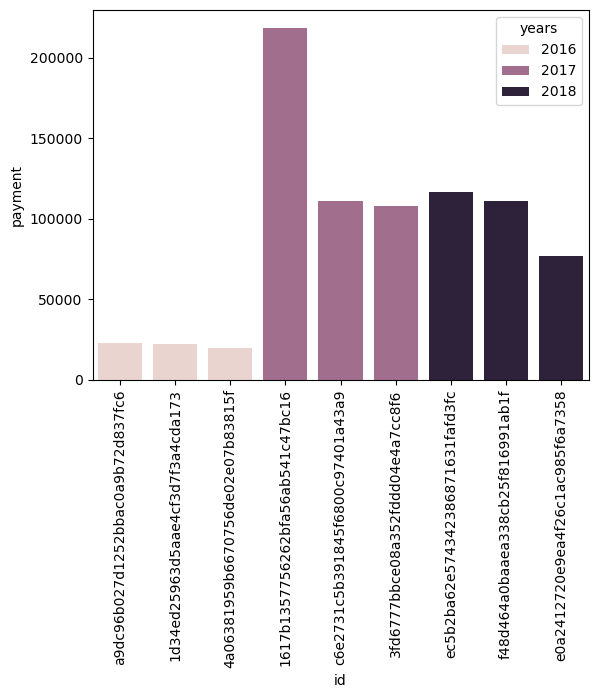

In [35]:
query = """SELECT years, customer_id, payment, d_rank
FROM
(SELECT YEAR(orders.order_purchase_timestamp) years,
orders.customer_id,
SUM(payments.payment_value) payment,
DENSE_RANK() OVER (PARTITION BY year (orders.order_purchase_timestamp)
ORDER BY SUM(payments.payment_value) desc) d_rank
FROM ORDERS JOIN PAYMENTS 
ON payments.order_id = orders.order_id
GROUP BY YEAR(orders.order_purchase_timestamp),
orders.customer_id) AS a
WHERE d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()